# Codepath Unit 10 and 11 - Project: Honeypot
---
#### Netsec & The Dark Side 

By: Mathias Lund Ahrn

Time spent: 8 hours

### Introduction

For this assignment a basic honeypot is set up to demonstrate the effectiveness of detecting and collection data for an attack.



### Setup

Google's cloud services is used for the cloud provider as codepath suggested.

- Two virtual machines created, one for the admin functionality named `MHN-admin`, the second for the honeypot named `honeypot-1`
- The honeypot machine allowing incoming traffic from all ports and protocols

---

*MHN-admin*
- Created: Nov 24, 2019, 11:41:59 PM
- Image: ubuntu-minimal-1804-bionic-v20191024

*honeypot-1*
- Created: Nov 23, 2019, 12:25:46 AM
- Image: ubuntu-minimal-1804-bionic-v20191024
- type: Ubuntu/Raspberry Pi - Dionaea over HTTP

---

###### Challenges with setup
First admin server would not work properly. It seemed like there were some issues with http/https connection through port 80. Tried to update the firewall without any luck. Rebuilt the instance and got the same issue one more time. Had to manually allow http and https traffic through the google console to make it work.

### Timeline

*Nov 24:* 
- Both the virtual machines where properly set up and started to track attacks. After only an hour it was registered 100+ attacks. Then the intention was to have these machines running through Thanksgiving week to collect more data from attacks.

*Nov 27:*
- Logged into the mhn-admin machine to create a copy of the tracked attacks so far. Downloaded this file and it had already gotten 1,811,082 attacks. Out of curiosity I let the machines still run.

*Dec 5:*
- Tried to log into mhn-admin without success, it would not respond after several tries. Then I tried to reboot the instances and I got in. Afterwards it seemed like due to amount of traffic it would stop work properly.
- Now I created a new dataset of the tracked attacks, this time the file had 4,140,381 rows of data. I expected more relative to the previous amount in regards of the timeframe, but when I looked at the timestamp for the last recorded attack it made sense. The last attack was dated: 2019-11-29 08:19:19, which has to be the latest before the system crashed/went down.

### Attack facts of the complete dataset

Due to the amount of data stored after operating for 5 days this file is to big (1.27 GB) to be stored at Github and it is difficult to work with. Here is the stats I got from it:

- Number of attacks: 4,140,381
- Type of attacks:
    - mssqld: 4,060,356
    - upnpd: 53,947
    - pcap: 16,386
    - Blackhole: 5,892
    - smbd: 2,960
    - httpd: 538
    - mysqld: 138
    - mongod: 38
    - ftpd: 37
    - SipSession: 32
    - microsoft-ds: 12
    - Memcache: 12
    - pptpd: 12
    - epmapper: 11
    - TftpServerHandler: 8
    - mqttd: 2
 
 
In order to have a workable dataset I cut out the last 200,000 attacks and seperated those into its own file. From this file I have done some python work to access more interesting facts like what country the attacks are comming from and which type of attacks.

---

## Exploration and stats

In [28]:
# code in this cell from: 
# https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to display/hide the code."></form>''')

In [5]:
import numpy as np
import pandas as pd
from multiprocessing import  Pool
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
from ip2geotools.databases.noncommercial import DbIpCity


data = "https://raw.githubusercontent.com/Certinax/datasets/master/network-security/session-test.json"
df = pd.read_json(data, lines=True)

In [6]:
def getCountry(x):
    location = DbIpCity.get(x, api_key='free')
    return location.country
    
def getCountryName(location):
    countryName = pycountry.countries.get(alpha_2=location).name
    return countryName

def add_countryCode(df):
    df["countryCode"] = df["source_ip"].apply(getCountry)
    return df

def add_countryName(df):
    df["country"] = df["countryCode"].apply(getCountryName)
    return df

def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [13]:
attack_frequency = df["source_ip"].value_counts()

## Getting all sources which have attacked more than 10 times
over_ten = pd.DataFrame(attack_frequency[attack_frequency.values >= 10]).reset_index()
over_ten = over_ten.rename(columns={"index":"source_ip", "source_ip":"freq"})

## Adding country code and country to the dataframe
df2 = parallelize_dataframe(over_ten, add_countryCode)
df2 = parallelize_dataframe(df2, add_countryName)

### How many different attackers from each country?

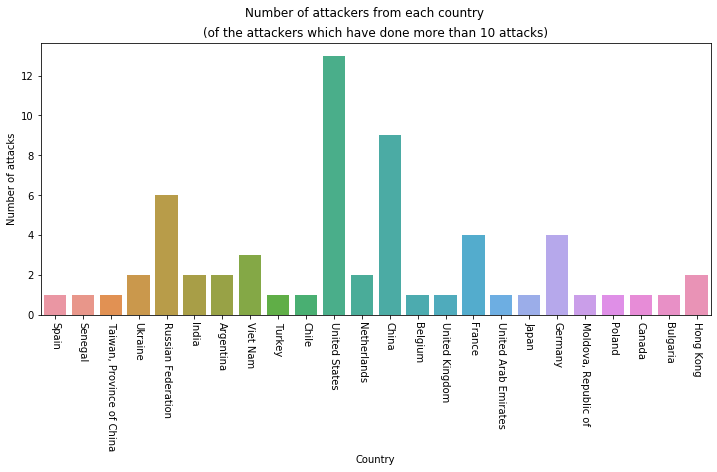

In [18]:
plt.figure(figsize=(12,5))
ax = sns.countplot(df2["country"])
plt.suptitle("Number of attackers from each country")
plt.title("(of the attackers which have done more than 10 attacks)")
plt.xlabel("Country")
plt.ylabel("Number of attacks")
plt.xticks(rotation=-90)
plt.show(ax)

From the graph we can see that Russia, Vietnam, United States, China, France and Germany have more than 3 different attackers to the honeypot, rest of the countries have 1 or 2 unique source ip's.

### How many attacks from each country?

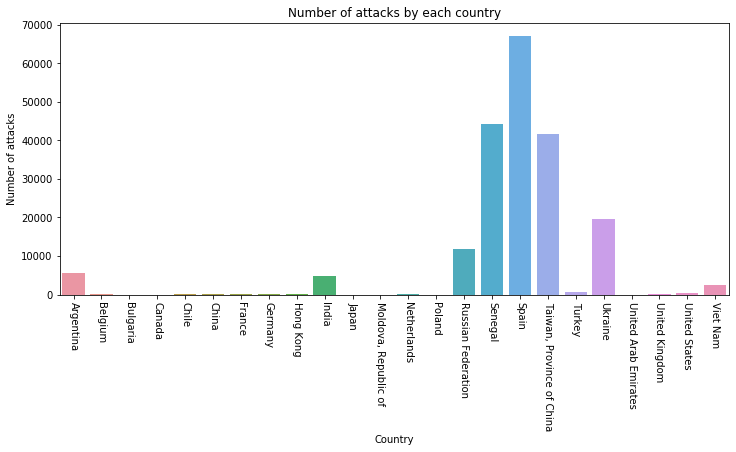

In [21]:
freq_per_country = df2.groupby("country")["freq"].agg(["sum"])

plt.figure(figsize=(12,5))
ax = sns.barplot(data=freq_per_country, x=freq_per_country.index, y="sum")
plt.title("Number of attacks by each country")
plt.ylabel("Number of attacks")
plt.xlabel("Country")
plt.xticks(rotation=-90)
plt.show(ax)

We can see that there are 5 countries that really shines out when it comes to number of attacks. Keep in mind that these attacks are only from the last 200,000 from the entire tracking period.

### What is the distribution of types of attack?

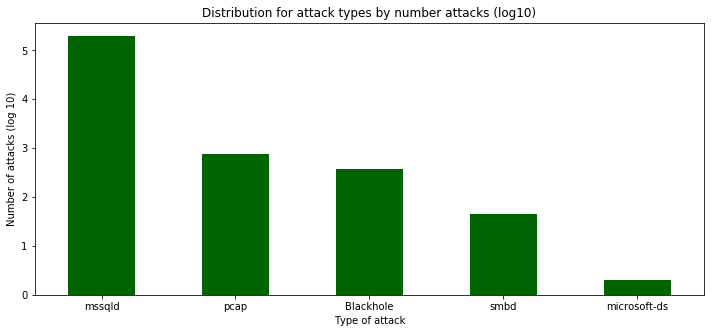

In [37]:
attack_type = df[df["source_ip"].isin(over_ten["source_ip"])]["protocol"]
log_attack_type = attack_type.value_counts().apply(np.log10)

plt.figure(figsize=(12,5))
log_attack_type.plot.bar(color="darkgreen")
plt.title("Distribution for attack types by number attacks (log10)")
plt.xticks(rotation=0)
plt.xlabel("Type of attack")
plt.ylabel("Number of attacks (log 10)");

The distribution of attacks shows that there are by far most mssql (Microsoft SQL), then we have portscanner (pcap), Blackhole (ddos), SMB (Server message block) and Microsoft-ds which also is a SMB attack.

## Summary

Due to the high number of DDoS attacks, this might be the reason my virtual machines got overloaded and crashed. I contacted Google Support regarding the crash and they could not find any problems on their side.

It would be interesting digging more into the complete dataset to see what kind of attacks occured most during the the whole timeframe and what countries stood for the most of attacks. 

Also using timestamps from the dataset could also discover interesting patterns between type of attacks, location and frequency.